# data preproccessing


## import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from functions.preproccessing import clean_columns, split_data, replace_outliers 

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

In [2]:
from config_and_dependencies.config import * 

### Import data

In [3]:
my_data = pd.read_csv(data_input_path)

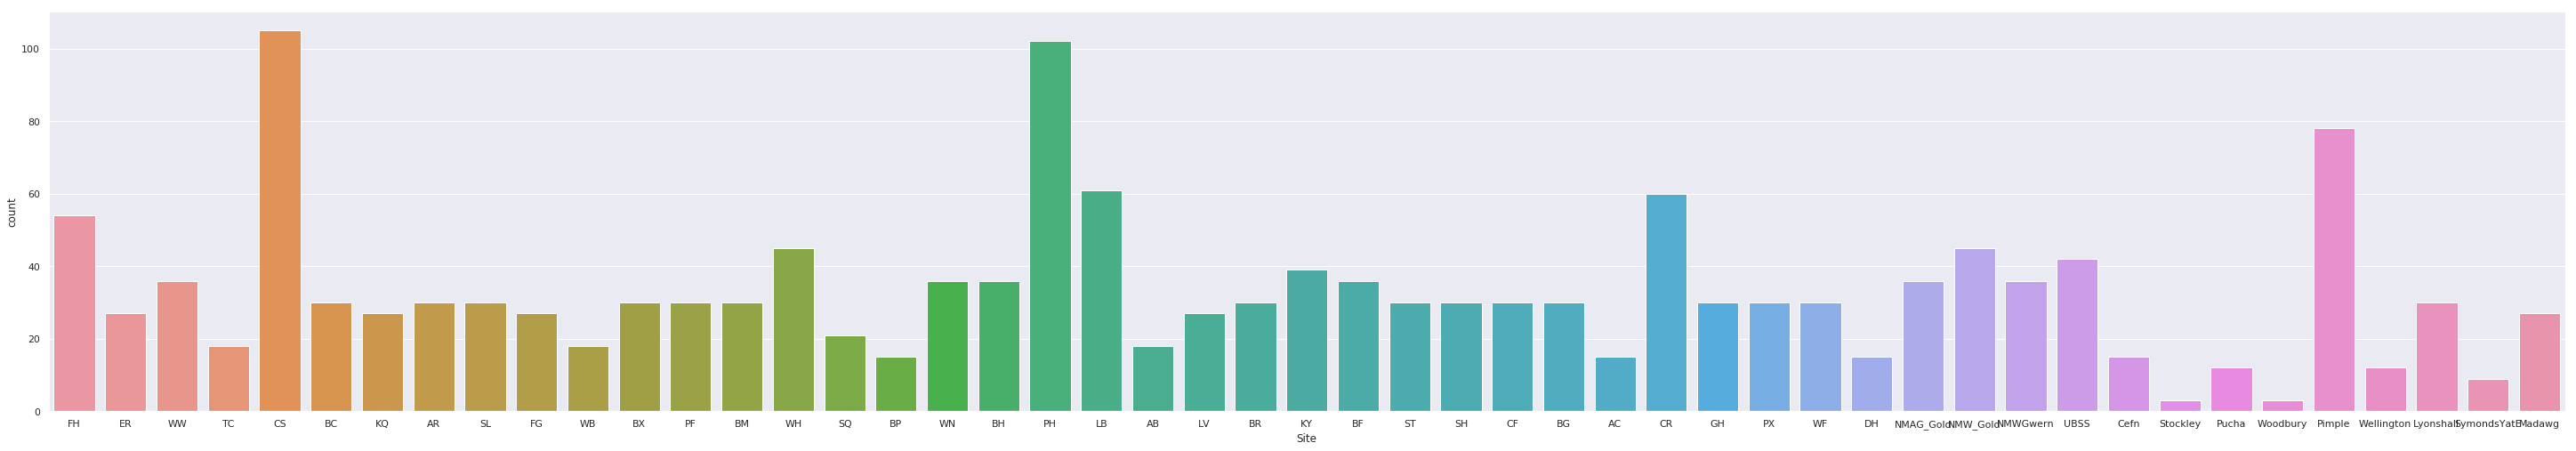

In [4]:
sns.set(rc={'figure.figsize':(50.7,8.27)})
sns.countplot(my_data['Site'])

In [28]:
my_data['class']

0         FH
1         FH
2         FH
3         FH
4         FH
5         FH
6         FH
7         FH
8         FH
9         FH
10        FH
11        FH
12        FH
13        FH
14        FH
15        FH
16        FH
17        FH
19        FH
20        FH
21        FH
22        FH
23        FH
24        FH
25        FH
26        FH
27        FH
28        FH
29        FH
30        FH
31        FH
32        FH
33        FH
34        FH
35        FH
36        FH
37        FH
38        FH
39        FH
40        FH
41        FH
42        FH
43        FH
44        FH
45        FH
46        FH
47        FH
48        FH
49        FH
50        FH
51        FH
52        FH
53        FH
54        ER
56        ER
57        ER
58        ER
59        ER
61        ER
62        ER
63        ER
64        ER
65        ER
66        ER
67        ER
68        ER
69        ER
70        ER
71        ER
73        ER
74        ER
75        ER
76        ER
77        ER
78        ER
79        ER
80        ER

### features

In [5]:
my_data.columns.values[features_start:features_end]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232'], dtype=object)

In [6]:
site_frequencies_df = pd.DataFrame(my_data.Site.value_counts()).reset_index(drop = False).rename(columns = {'Site':'Number of Observations', 'index':'Site'})
%store site_frequencies_df

Stored 'site_frequencies_df' (DataFrame)


### raw sample names including sample sites and artefacts

In [7]:
my_data['Site'].unique()

array(['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB',
       'BX', 'PF', 'BM', 'WH', 'SQ', 'BP', 'WN', 'BH', 'PH', 'LB', 'AB',
       'LV', 'BR', 'KY', 'BF', 'ST', 'SH', 'CF', 'BG', 'AC', 'CR', 'GH',
       'PX', 'WF', 'DH', 'NMAG_Gold', 'NMW_Gold', 'NMWGwern', 'UBSS',
       'Cefn', 'Stockley', 'Pucha', 'Woodbury', 'Pimple', 'Wellington',
       'Lyonshall', 'SymondsYatE', 'Madawg', nan], dtype=object)

### define functions for making target classes for classification

In [8]:

def make_classes_grouped_reduced(row):
    if row['Geology'] == 'Bedrock':
        return(row['Site'])
    elif row['Geology'] == 'Superficial':
        if row['Region'] == 'SV' or row['Region'] == 'SE':
            return('SV_SE')
        else:
            return(row['Region'])

### targets for classification are made

In [9]:
my_data['class'] = my_data.apply(make_classes_grouped_reduced, axis = 1)

### remove bedrock site 'BP' because class-specific F1 score was very bad due to limited sample number 

In [10]:
my_data = my_data[my_data['Site']!='BP']
my_data = my_data[my_data['Site']!='BX']


if bedrock_only:
    my_superficial = my_data[my_data['Geology'] == 'Superficial']
    my_data = my_data[my_data['Geology'] != 'Superficial']


In [11]:
if drop_semi_bedrock:
    my_data = my_data[(my_data['class'] != 'BM') & (my_data['class'] != 'BC') & (my_data['class'] != 'BP') ]

In [12]:
my_data['class'].unique()

array(['FH', 'ER', 'WW', 'TC', 'CS', 'KQ', 'AR', 'SL', 'FG', 'WB', 'PF',
       'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', None], dtype=object)

### remove '<' signs and commas from feature values

In [13]:
my_data = clean_columns(my_data, 9, -1)    
my_superficial = clean_columns(my_superficial, 9, -1)

Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 23585.33it/s]

Li7



Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22374.40it/s]


Be9
B11
Mg24


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21698.43it/s]


Al27
Si28


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22312.86it/s]


P31
S33


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22413.67it/s]


K39
Ca42


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 20773.82it/s]


Sc45
Ti47


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22160.91it/s]


V51
Cr52


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22626.01it/s]


Mn55
Fe56


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 20667.97it/s]


Co59
Ni60


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 20390.38it/s]


Cu63
Zn68


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22035.49it/s]


Ga69
Ge72


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21751.43it/s]


As75


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22727.18it/s]


Rb85
Sr88


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22866.36it/s]


Y89
Zr90


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 18263.13it/s]


Nb93
Mo95


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 18828.42it/s]


Cd111
In115


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 20150.84it/s]


Sn118
Cs133


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21950.09it/s]


Ba137
La139


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21930.66it/s]


Ce140
Pr141


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 20061.20it/s]


Nd146
Sm147


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 22093.68it/s]


Eu153
Gd157


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21569.70it/s]


Tb159
Dy163


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21316.77it/s]


Ho165
Er166


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21253.86it/s]


Tm169
Yb172


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21163.79it/s]


Lu175
Hf178


Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21442.18it/s]

Ta181



Pandas Apply: 100%|██████████| 1087/1087 [00:00<00:00, 21399.31it/s]


Pb208
Th232
U238


Pandas Apply:   0%|          | 0/435 [00:00<?, ?it/s]

Li7
Be9


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 16688.82it/s]


B11
Mg24
Al27


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 17828.05it/s]


Si28
P31
S33


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 19138.21it/s]


K39
Ca42
Sc45


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 19762.81it/s]


Ti47
V51
Cr52


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 16832.16it/s]


Mn55
Fe56
Co59


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 19718.60it/s]


Ni60
Cu63
Zn68


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 18476.17it/s]


Ga69
Ge72
As75


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 21111.54it/s]


Rb85
Sr88
Y89


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 20308.12it/s]


Zr90
Nb93
Mo95


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 19226.95it/s]


Cd111
In115
Sn118


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 19376.83it/s]


Cs133
Ba137
La139


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 20389.14it/s]


Ce140
Pr141
Nd146


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 20659.02it/s]


Sm147
Eu153
Gd157


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 20762.94it/s]


Tb159
Dy163
Ho165


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 20339.82it/s]


Er166
Tm169
Yb172


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 17977.36it/s]


Lu175
Hf178
Ta181


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 21091.52it/s]


Pb208
Th232
U238


Pandas Apply: 100%|██████████| 435/435 [00:00<00:00, 20606.99it/s]


### visualise na values

sns.set(rc={'figure.figsize':(20.7,50)})
sns.heatmap(my_data.isna(), cbar=False)

### remove rows where there are all element abundances are na values 

In [14]:
my_data = my_data.dropna(subset=my_data.columns.values[9:-1], how = 'all' , axis = 0)
my_superficial = my_superficial.dropna(subset=my_superficial.columns.values[9:-1], how = 'all' , axis = 0)

### split data into 'train_data' and 'test_data', the former consists of samples from known geological sites and the latter from flint artefacts fow which the original geological source site is unknown and to be predicted.

In [15]:
my_data_split_geological, my_data_split_artefacts = split_data(my_data, 'Geology','Artefacts')

### Impute na values with feature mean

In [16]:
for column_name in my_data_split_geological.columns.values[9:-1]:
    my_data_split_geological[column_name] = my_data_split_geological[column_name].fillna(my_data_split_geological[column_name].mean()) 

for column_name in my_data_split_artefacts.columns.values[9:-1]:
    my_data_split_artefacts[column_name] = my_data_split_artefacts[column_name].fillna(my_data_split_artefacts[column_name].mean())  
    
for column_name in my_superficial.columns.values[9:-1]:
    my_superficial[column_name] = my_superficial[column_name].fillna(my_superficial[column_name].mean())


/home/rmorse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rmorse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Outliers defined as any values that exceed 2 standard deviations from the mean, such values are changed to the mean for that variable

In [17]:
my_data_split_geological = replace_outliers(my_data_split_geological, features_start, features_end, num_stds = 2)
my_data_split_artefacts = replace_outliers(my_data_split_artefacts, features_start, features_end, num_stds = 2)
my_superficial = replace_outliers(my_superficial, features_start, features_end, num_stds = 2)

Pandas Apply: 100%|██████████| 696/696 [00:00<00:00, 25188.19it/s]
/home/rmorse/developer/machine_learning/paper_1_notebooks/functions/preproccessing.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)
Pandas Apply: 100%|██████████| 432/432 [00:00<00:00, 22967.92it/s]


In [18]:
print(my_data_split_geological['Geology'].unique())
print(my_data_split_artefacts['Geology'].unique())
print(my_superficial['Geology'].unique())

['Bedrock']
['Artefacts']
['Superficial']


In [19]:
train_data = my_data_split_geological.copy(deep = True)
test_data = my_data_split_artefacts.copy(deep = True)


### label encode the class to be predicted

In [20]:
if bedrock_only:
    train_data_formodel = train_data[train_data['Geology'] == 'Bedrock'].copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
else:
    train_data_formodel = train_data.copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])


### datasets are stored

In [21]:
%store train_data_formodel
%store train_data
%store test_data
%store my_data
%store uniques

Stored 'train_data_formodel' (DataFrame)
Stored 'train_data' (DataFrame)
Stored 'test_data' (DataFrame)
Stored 'my_data' (DataFrame)
Stored 'uniques' (Index)


## data preproccessing for dimensionality reduction and visualisation

### four datasets are created, one containing all train data (bedrock and superficial types), one containing just bedrock types, one containing just superficial types and one containing the artefacts

In [22]:
#element_data_train = train_data[train_data.columns.values[9:-1]]
element_data_train_bedrock = train_data[train_data.columns.values[9:-1]]
element_data_train_superficial = my_superficial[my_superficial.columns.values[9:-1]]
element_data_test = test_data[test_data.columns.values[9:-1]]

### features are standardised

In [23]:
my_scaler_train = StandardScaler()
my_scaler_train_bedrock = StandardScaler()
my_scaler_train_superficial = StandardScaler()
my_scaler_test = StandardScaler()

In [24]:
#element_data_train_scaled = my_scaler_train.fit_transform(element_data_train)
element_data_train_bedrock_scaled = my_scaler_train_bedrock.fit_transform(element_data_train_bedrock)
element_data_train_superficial_scaled = my_scaler_train_superficial.fit_transform(element_data_train_superficial)
element_data_test_scaled = my_scaler_test.fit_transform(element_data_test)

### T-Distributed Stochastic Neighbour Embedding is done on the four datasets

In [25]:
#my_tsne_train = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_train_scaled)
my_tsne_bedrock_train = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_train_bedrock_scaled)
my_tsne_superficial_train = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_train_superficial_scaled)
my_tsne_test = TSNE(n_components=2, n_iter=10000, verbose=3, random_state=random_seed_state).fit_transform(element_data_test_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 696 samples in 0.001s...
[t-SNE] Computed neighbors for 696 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 696 / 696
[t-SNE] Mean sigma: 2.194450
[t-SNE] Computed conditional probabilities in 0.040s
[t-SNE] Iteration 50: error = 72.6145859, gradient norm = 0.4021802 (50 iterations in 0.320s)
[t-SNE] Iteration 100: error = 73.0112534, gradient norm = 0.3905257 (50 iterations in 0.320s)
[t-SNE] Iteration 150: error = 72.5663605, gradient norm = 0.4193480 (50 iterations in 0.345s)
[t-SNE] Iteration 200: error = 73.5665207, gradient norm = 0.4036619 (50 iterations in 0.329s)
[t-SNE] Iteration 250: error = 74.1057205, gradient norm = 0.3846155 (50 iterations in 0.334s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.105721
[t-SNE] Iteration 300: error = 1.2320886, gradient norm = 0.0046994 (50 iterations in 0.226s)
[t-SNE] Iteration 350: error = 1.1329243, gradient norm = 0.0006182 (

### the t-SNE dimensions for the four datasets are put into dataframes

In [26]:
#tsne_df_train = pd.DataFrame(data = my_tsne_train, columns = ['tsne1', 'tsne2'])
tsne_df_bedrock_train = pd.DataFrame(data = my_tsne_bedrock_train, columns = ['tsne1', 'tsne2'])
tsne_df_superficial_train = pd.DataFrame(data = my_tsne_superficial_train, columns = ['tsne1', 'tsne2'])
tsne_df_test = pd.DataFrame(data = my_tsne_test, columns = ['tsne1', 'tsne2'])

### datasets are stored for the purpose of two-dimensional visualisations

In [27]:
#%store tsne_df_train

%store tsne_df_bedrock_train
%store tsne_df_superficial_train


%store tsne_df_test

%store my_superficial

Stored 'tsne_df_bedrock_train' (DataFrame)
Stored 'tsne_df_superficial_train' (DataFrame)
Stored 'tsne_df_test' (DataFrame)
Stored 'my_superficial' (DataFrame)
